In [7]:
from chessnet.notebook_config import *
from chessnet.graphs import  read_degree_and_elo
from chessnet.rich_club import read_rich_club, read_rich_club_elo

from scipy.signal import savgol_filter

In [2]:
def filter(X):
    return savgol_filter(X, 101, 3)

In [3]:
node_dfs = {
    "OTB": read_degree_and_elo(Database.OTB),
    "Portal": read_degree_and_elo(Database.Portal),
}

In [4]:
def get_elo_vs_k(node_df, bins: int = 20):
    X = np.logspace(1, np.log10(max(node_df.k)+1), bins).astype(int)
    mean_values = []
    std_values = []
    for i in range(len(X)-1):
        mink, maxk = X[i], X[i+1]
        elos = node_df[(mink <= node_df.k) & (node_df.k < maxk)].MeanElo
        mean_values.append(elos.mean())
        std_values.append(elos.std())
    return np.array(X), np.array(mean_values), np.array(std_values)

In [8]:
samples = 500
rich_club_data = {
    "OTB": read_rich_club("OM_OTB_201609", samples=samples),
    "Portal": read_rich_club("OM_Portal_201510", samples=samples)
}
rich_club_elo_data = {
    "OTB": read_rich_club_elo("OM_OTB_201609", samples=samples),
    "Portal": read_rich_club_elo("OM_Portal_201510", samples=samples)
}
for name in ["OTB", "Portal"]:
    rich_club_data[name]["phi_filter"] = filter(rich_club_data[name]["phi"])
    rich_club_data[name]["phi_ran_filter"] = filter(rich_club_data[name]["rand_phi"])
    rich_club_data[name]["rho_filter"] = (
        rich_club_data[name]["phi_filter"] / rich_club_data[name]["phi_ran_filter"]
    )

    

    rich_club_elo_data[name]["phi_filter"] = filter(rich_club_elo_data[name]["phi"])
    rich_club_elo_data[name]["phi_ran_filter"] = filter(rich_club_elo_data[name]["ran_phi"])
    rich_club_elo_data[name]["rho_filter"] = (
        rich_club_elo_data[name]["phi_filter"] / rich_club_elo_data[name]["phi_ran_filter"]
    )
    rich_club_elo_data[name]["phi_ran_elo_filter"] = filter(rich_club_elo_data[name]["ran_elo_phi"])
    rich_club_elo_data[name]["rho_elo_filter"] = (
        rich_club_elo_data[name]["phi_filter"] / rich_club_elo_data[name]["phi_ran_elo_filter"]
    )

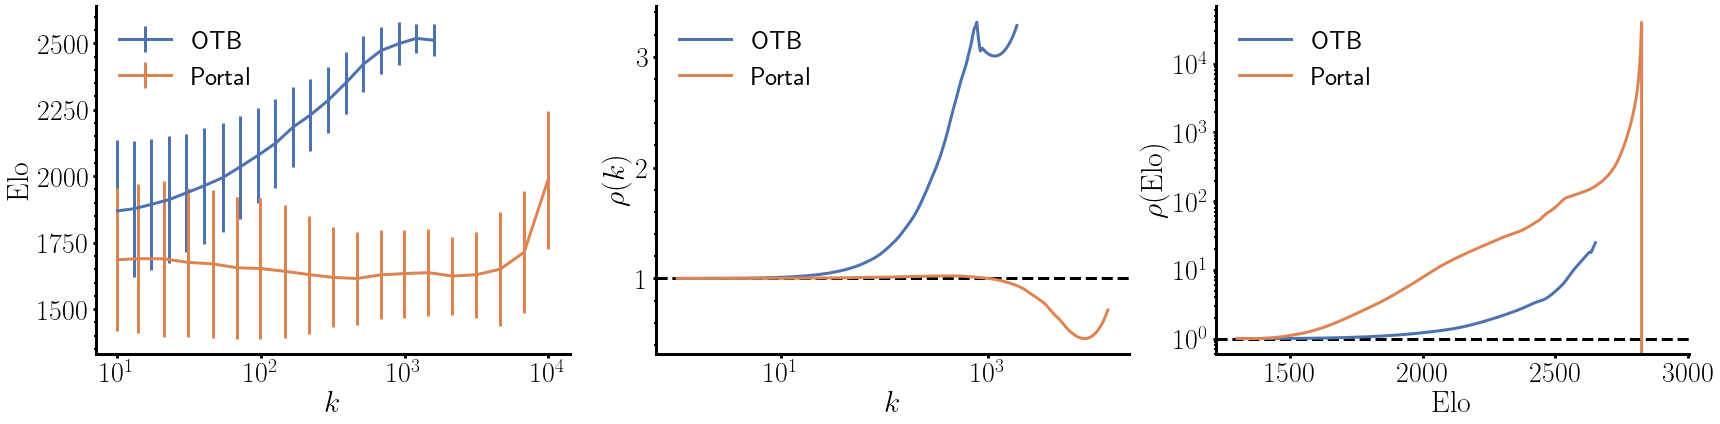

In [42]:
from scipy.signal import savgol_filter
#yhat = savgol_filter(y, 51, 3) # window size 51, polynomial order 3

ncols, nrows = 3, 1
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

ax = axes[0]
ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$\mathrm{Elo}$")
ax.set_xscale("log")
for name, node_df in node_dfs.items():
    X, mean_values, std_values = get_elo_vs_k(node_df)
    ax.errorbar(X[:-1], mean_values, std_values, label=name)

ax = axes[1]
ax.set_xscale("log")
ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$\rho(k)$")
ax.axhline(1, color="k", linestyle="--")
for name, df in rich_club_data.items():
    #ax.plot(df.k, df.rho, label=name)
    ax.plot(df.k, df.rho_filter, label=name)

ax = axes[2]
ax.set_yscale("log")
ax.set_xlabel(r"$\mathrm{Elo}$")
ax.set_ylabel(r"$\rho(\mathrm{Elo})$")
ax.axhline(1, color="k", linestyle="--")
for name, df in rich_club_elo_data.items():
    #ax.plot(df.elo, df.rho_elo, label=name)
    rho_values = df.rho_filter
    mask = rho_values.notna() & (rho_values < 1e6)
    ax.plot(df.elo[mask], rho_values[mask], label=name)

for ax in axes:
    ax.legend(frameon=False)

sns.despine()

plt.tight_layout()
plt.show()

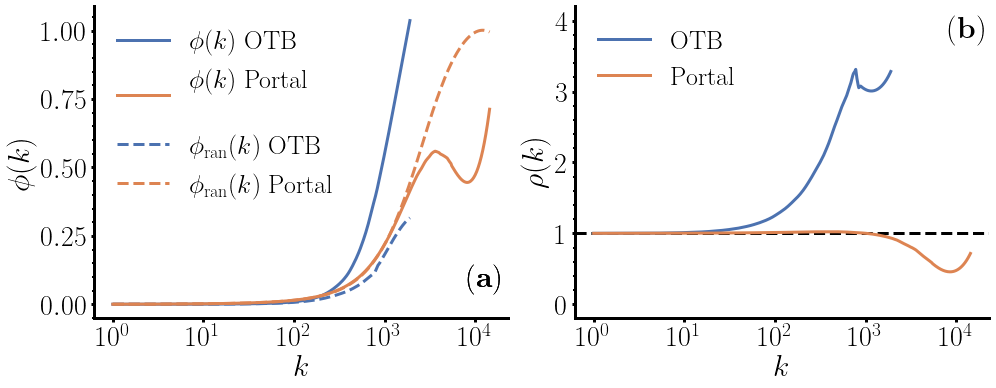

In [13]:
ncols, nrows = 2, 1
fig, axes = plt.subplots(figsize=(7*ncols, 5.5*nrows), ncols=ncols, nrows=nrows)

for i, (name, df) in enumerate(rich_club_data.items()):
    ax = axes[0]
    ax.text(0.9, 0.1, panels[0], fontsize=30, transform=ax.transAxes)
    ax.set_xlabel(r"$k$")
    ax.set_ylabel(r"$\phi(k)$")
    ax.set_xscale("log")
    ax.plot(
        df.k,
        df.phi_filter,
        label=r"$\phi(k)\;" + database_latex[name][1:],
        color=f"C{i}",
        )
    ax.plot(
        df.k,
        df.phi_ran_filter,
        label=r"$\phi_{\mathrm{ran}}(k)\;" + database_latex[name][1:],
        color=f"C{i}",
        linestyle="--",
    )
handles, labels = ax.get_legend_handles_labels()
order = [0, 2, 1, 3]
legend1 = ax.legend(
        [handles[idx] for idx in order],[labels[idx] + ("\n" if idx == 2 else "") for idx in order],
        frameon=False
    )
if False:
    legend1 = ax.legend(
        [handles[idx] for idx in order],[labels[idx] for idx in [1,3]],
        frameon=False, loc=(0.02, 0.4)
    )

    legend2 = ax.legend(
        [handles[idx] for idx in order],[labels[idx] for idx in [0,2]],
        frameon=False
    )


    ax.add_artist(legend1)

ax = axes[1]
ax.text(0.9, 0.9, panels[1], fontsize=30, transform=ax.transAxes)
ax.set_ylim(-0.2, 4.2)
ax.set_xscale("log")
ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$\rho(k)$")
ax.axhline(1, color="k", linestyle="--")
for name, df in rich_club_data.items():
    ax.plot(df.k, df.rho_filter, label=database_latex[name])

for ax in axes:
    ax.set_xticks([1, 10, 100, 1000, 10000])
ax.legend(frameon=False)

sns.despine()
plt.tight_layout()
plt.savefig(FIGS_DIR / "rich_club.pdf")
plt.show()

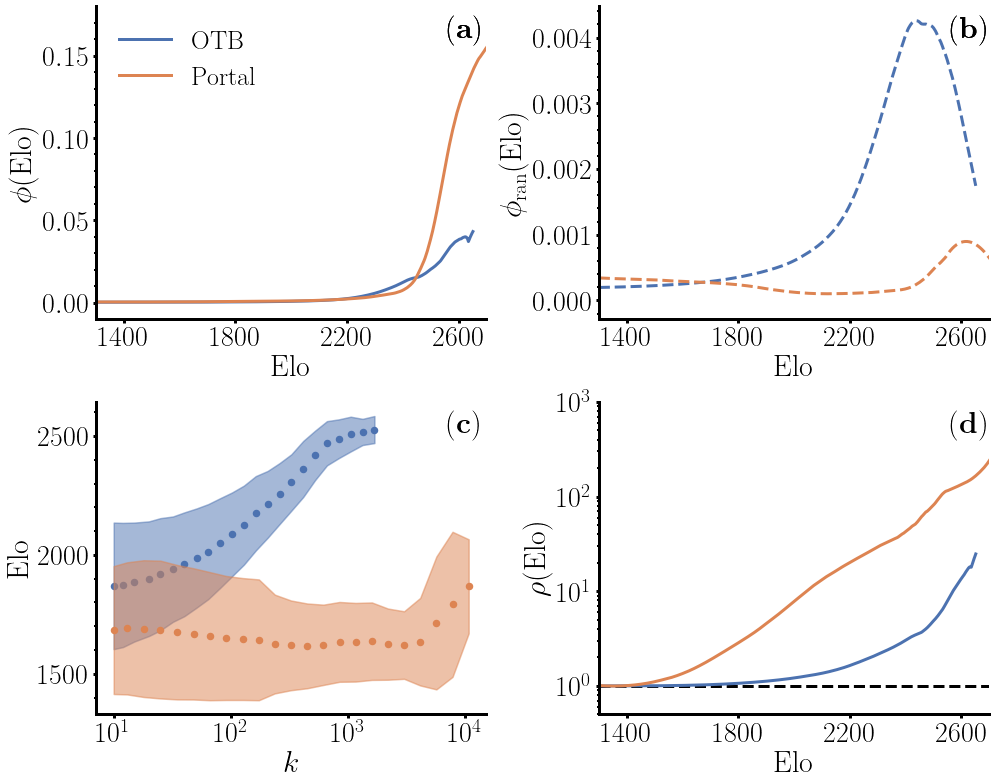

In [17]:
ncols, nrows = 2, 2
fig, axes = plt.subplots(figsize=(7*ncols, 5.5*nrows), ncols=ncols, nrows=nrows)

for i, (name, df) in enumerate(rich_club_elo_data.items()):
    ax = axes[0,0]
    ax.text(0.9, 0.9, panels[0], fontsize=30, transform=ax.transAxes)
    ax.set_ylim(-0.01, 0.18)
    ax.set_xlabel(r"$\mathrm{Elo}$")
    ax.set_ylabel(r"$\phi(\mathrm{Elo})$")
    ax.plot(
        df.elo,
        df.phi_filter,
        label=database_latex[name],
        color=f"C{i}",
        )
    ax = axes[0,1]
    ax.text(0.9, 0.9, panels[1], fontsize=30, transform=ax.transAxes)
    ax.set_xlabel(r"$\mathrm{Elo}$")
    ax.set_ylabel(r"$\phi_{\mathrm{ran}}(\mathrm{Elo})$")
    ax.plot(
        df.elo,
        df.phi_ran_filter,
        color=f"C{i}",
        linestyle="--",
    )
axes[0,0].legend(frameon=False)

ax = axes[1,0]
ax.text(0.9, 0.9, panels[2], fontsize=30, transform=ax.transAxes)
ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$\mathrm{Elo}$")
ax.set_xscale("log")
for i, (name, node_df) in enumerate(node_dfs.items()):
    X, mean_values, std_values = get_elo_vs_k(node_df, bins=24)
    #ax.errorbar(X[:-1], mean_values, std_values, label=name)
    ax.scatter(X[:-1], mean_values, label=name, color=f"C{i}")
    ax.fill_between(X[:-1], mean_values-std_values, mean_values+std_values, alpha=0.5, color=f"C{i}")
ax.set_xticks([10, 100, 1000, 10000])

ax = axes[1,1]
ax.text(0.9, 0.9, panels[3], fontsize=30, transform=ax.transAxes)
ax.set_xlabel(r"$\mathrm{Elo}$")
ax.set_ylabel(r"$\rho(\mathrm{Elo})$")
ax.axhline(1, color="k", linestyle="--")
for name, df in rich_club_elo_data.items():
    ax.plot(df.elo, df.rho_filter, label=database_latex[name])
ax.set_yscale("log")
ax.set_ylim(0.5, 1000)

for i, ax in enumerate(axes.flatten()):
    if i == 2:
        continue
    ax.set_xlim(1300, 2700)
    ax.set_xticks([1400, 1800, 2200, 2600])

sns.despine()
plt.tight_layout()
plt.savefig(FIGS_DIR / "rich_club_elo.pdf")
plt.show()